# Configuration

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [ ]:
def sliding_window(data, window_size, step_size):
  input, label = [], []

  for i in range(window_size, len(data)-step_size+1):
    input.append(data[i-window_size:i,:])
    label.append(data[i:i+step_size,-1])
  
  return input, label

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.Tensor(np.array(x)).float().to(device)
    self.y = torch.Tensor(np.array(y)).float().to(device)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return len(self.x)

In [ ]:
# load the train data
train1 = np.genfromtxt('./train1.txt', delimiter='')
train2 = np.genfromtxt('./train2.txt', delimiter='')

# min-max scaling
amax1 = np.amax(train1, axis=0)
amin1 = np.amin(train1, axis=0)

amax2 = np.amax(train2, axis=0)
amin2 = np.amin(train2, axis=0)

amax = np.maximum(amax1, amax2)
amin = np.minimum(amin1, amin2)

train1 = (train1 - amin) / (amax - amin)
train2 = (train2 - amin) / (amax - amin)

# sliding window
x1, y1 = sliding_window(data=train1, window_size=18, step_size=1)
x2, y2 = sliding_window(data=train2, window_size=18, step_size=1)

# concatenate
x = x1 + x2
y = y1 + y2

# dataset, dataloader
train = TimeSeriesDataset(x, y)
dataloader = DataLoader(dataset=train, batch_size=32, shuffle=True)

# Model

In [ ]:
class CustomLayerNormLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CustomLayerNormLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    gate_size = 4 * hidden_size

    self.w_ih = nn.Parameter(torch.Tensor(self.input_size, gate_size))
    self.w_hh = nn.Parameter(torch.Tensor(self.hidden_size, gate_size))
    
    self.b = nn.Parameter(torch.Tensor(gate_size))

    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

    self.ln_gains = nn.Parameter(torch.ones(gate_size, gate_size))
    self.ln_bias = nn.Parameter(torch.zeros(gate_size))

  def forward(self, x, init_states=None):
    B, L = x.size(0), x.size(1)
    output = []
    eps = 1e-5

    if init_states is None:
      ht, ct = (torch.zeros(B, self.hidden_size).to(device), 
                torch.zeros(B, self.hidden_size).to(device))
    else:
      ht, ct = init_states

    for t in range(L):
      xt = x[:,t,:]
      gates = xt @ self.w_ih + ht @ self.w_hh + self.b

      mean = gates.mean(1).unsqueeze(1)
      var = gates.var(1).unsqueeze(1)

      gates = (gates - mean) / torch.sqrt(var + eps)
      gates = gates @ self.ln_gains + self.ln_bias

      it = torch.sigmoid(gates[:,:self.hidden_size])
      ft = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
      gt = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
      ot = torch.sigmoid(gates[:,3*self.hidden_size:])

      ct = ft * ct + it + gt
      ht = ot * torch.tanh(ct)

      output.append(ht.unsqueeze(1))

    output = torch.cat(output, dim=1)
    return output, (ht, ct)

In [ ]:
class TimeSeriesForecasting(nn.Module):
  def __init__(self, input_size, hidden_size, step_size):
    super(TimeSeriesForecasting, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.step_size = step_size
    
    linear_size = self.step_size * self.hidden_size

    self.weight = nn.Parameter(torch.Tensor(linear_size, 1))
    self.bias = nn.Parameter(torch.Tensor(self.step_size))

    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

    self.lstm = nn.ModuleList([CustomLayerNormLSTM(input_size+step-1, hidden_size) for step in range(1, step_size+1)])

  def forward(self, x):
    input, label = x[:,:,:-1], x[:,:,-1]
    yhat = []
    for step in range(self.step_size):
      weight = self.weight[step*self.hidden_size:(step+1)*self.hidden_size,:]
      bias = self.bias[step]
      # 1st step prediction
      if yhat == []:
        out, (ht, ct) = self.lstm[step](x)
        pred = ht @ weight + bias
        yhat.append(pred)
      # 2nd, 3rd, ... , nth step prediction
      else:
        label = torch.cat([label, yhat[-1]], dim=1)
        window = []
        for i in range(x.size(1)):
          window.append(label[:,i:i+step+1].unsqueeze(1))
        ycat = torch.cat(window, dim=1)
        x = torch.cat([input, ycat], dim=2)
        out, (ht, ct) = self.lstm[step](x, (ht, ct))
        pred = ht @ weight + bias
        yhat.append(pred)
    out = torch.cat(yhat, dim=1)
    return out

# Train

In [ ]:
model = TimeSeriesForecasting(input_size=9, hidden_size=13, step_size=1).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(with_plot=True):
  train_history = []
  model.train()

  for epoch in range(100):
    avg_batch_loss = 0

    for i, data in enumerate(dataloader):
      input, label = data
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, label)
      avg_batch_loss += loss.item()
      loss.backward()
      optimizer.step()
    
    avg_batch_loss /= len(dataloader)
    train_history.append(avg_batch_loss)

    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, avg_batch_loss))
  
  if with_plot:
    fig = plt.figure(figsize=(10, 4))
    plt.plot(train_history)
    plt.show()

Epoch: 0, loss: 0.01314
Epoch: 10, loss: 0.00017
Epoch: 20, loss: 0.00016
Epoch: 30, loss: 0.00014
Epoch: 40, loss: 0.00010
Epoch: 50, loss: 0.00009
Epoch: 60, loss: 0.00007
Epoch: 70, loss: 0.00009
Epoch: 80, loss: 0.00007
Epoch: 90, loss: 0.00007


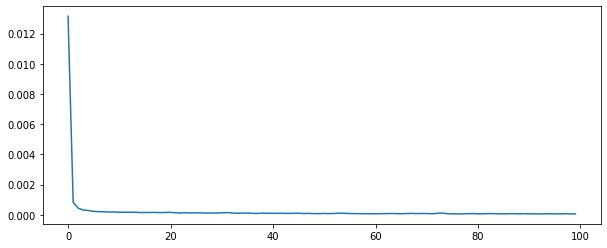

In [ ]:
train()

# Test

In [ ]:
# load the test data
test = np.genfromtxt('./test.txt', delimiter='')

# min-max scaling
amax = np.amax(test, axis=0)
amin = np.amin(test, axis=0)

test = (test - amin) / (amax - amin)

# sliding window
x, y = sliding_window(data=test, window_size=18, step_size=1)

# dataset
test = TimeSeriesDataset(x, y)

In [ ]:
def show_performance(with_plot=True):
  model.eval()
  
  with torch.no_grad():
    label, pred = [], []
    rmse = 0

    for i in range(len(test)):
      x, y = test.__getitem__(i)
      x = x.unsqueeze(0)
      output = model(x)

      y = y.cpu().detach().numpy()
      y = y * (amax[-1] - amin[-1]) + amin[-1]
      label.append(y)

      output = output.squeeze(1)
      output = output.cpu().detach().numpy()
      output = output * (amax[-1] - amin[-1]) + amin[-1]
      pred.append(output)

      rmse += (y - output)**2
    
    rmse /= len(test)
    rmse = math.sqrt(rmse)

    if with_plot:
      fig = plt.figure(figsize = (10, 4))
      plt.plot(label, label='label')
      plt.plot(pred, label='prediction')
      plt.legend()
      plt.show()

  return rmse

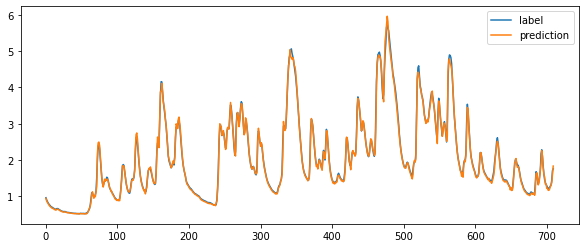

RMSE : 0.06830091701687155


In [ ]:
rmse = show_performance()
print(f'RMSE : {rmse}')

# Performance Test

In [ ]:
avg_rmse = 0

for i in range(100):
  model = TimeSeriesForecasting(input_size=9, hidden_size=13, step_size=1).to(device)

  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  train(with_plot=False)

  rmse = show_performance(with_plot=False)
  avg_rmse += rmse

  print('=========================')
  print('Test %d, loss : %1.5f' % (i+1, rmse))
  print('=========================')

avg_rmse /= 100

print(f'Average RMSE : {avg_rmse}')

Epoch: 0, loss: 0.00893
Epoch: 10, loss: 0.00016
Epoch: 20, loss: 0.00011
Epoch: 30, loss: 0.00010
Epoch: 40, loss: 0.00008
Epoch: 50, loss: 0.00007
Epoch: 60, loss: 0.00008
Epoch: 70, loss: 0.00007
Epoch: 80, loss: 0.00006
Epoch: 90, loss: 0.00006
Test 1, loss : 0.07866
Epoch: 0, loss: 0.01254
Epoch: 10, loss: 0.00019
Epoch: 20, loss: 0.00014
Epoch: 30, loss: 0.00010
Epoch: 40, loss: 0.00009
Epoch: 50, loss: 0.00008
Epoch: 60, loss: 0.00008
Epoch: 70, loss: 0.00007
Epoch: 80, loss: 0.00006
Epoch: 90, loss: 0.00005
Test 2, loss : 0.08582
Epoch: 0, loss: 0.02308
Epoch: 10, loss: 0.00019
Epoch: 20, loss: 0.00013
Epoch: 30, loss: 0.00012
Epoch: 40, loss: 0.00010
Epoch: 50, loss: 0.00010
Epoch: 60, loss: 0.00008
Epoch: 70, loss: 0.00008
Epoch: 80, loss: 0.00008
Epoch: 90, loss: 0.00006
Test 3, loss : 0.09661
Epoch: 0, loss: 0.01906
Epoch: 10, loss: 0.00018
Epoch: 20, loss: 0.00014
Epoch: 30, loss: 0.00010
Epoch: 40, loss: 0.00008
Epoch: 50, loss: 0.00009
Epoch: 60, loss: 0.00008
Epoch: 70,

# Hyper-parameter Tuning